In [1]:
import sympy as sp
from sympy import diff, sin, cos, exp, sqrt, Rational, Matrix
from quantum_electron import package_versions

import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import electron_mass, elementary_charge

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['font.family'] = 'Arial'

package_versions()

quantum_electron 0.2.1
numpy 1.24.2
scipy 1.11.4
matplotlib 3.7.1


# Calculation of the electron capacitance

In this section, we calculate an analytical expression for the electron eigenfrequencies. These expressions are used to find the capacitance of a single electron. We'll start with the eigensystem for a single electron moving in the 1D plane coupled to an LC resonator. 

In [2]:
me, e, L, C, alpha, alpha2, omega0, omegae = sp.symbols('m_e e L C α α_2 ω_0, ω_e')

The matrix equation that describes the equations of motion is given by 
$$
\omega^2 [\mathbf{M}] \vec{q} = [\mathbf{K}] \vec{q},
$$
and therefore, the eigenvalues of the matrix $[\mathbf{M}]^{-1}[\mathbf{K}]$ are the squared eigenfrequencies $\omega^2$.

In [3]:
MinvK = Matrix([[1 / (L * C), e * alpha / (L * C)], 
            [e * alpha / (me * C), omegae ** 2]])

In [4]:
evals = MinvK.eigenvals()

Since it's a 2x2 matrix, there are 2 eigenvalues. Let's take a look at the first eigenvalue

In [5]:
list(evals.keys())[0].subs(L, 1/(omega0**2 * C)).simplify()

(m_e*ω_0**2 + m_e*ω_e**2 - ω_0**2*sqrt(m_e*(m_e - 2*m_e*ω_e**2/ω_0**2 + m_e*ω_e**4/ω_0**4 + 4*e**2*α**2/(C*ω_0**2))))/(2*m_e)

The second eigenvalue is similar in structure

In [6]:
list(evals.keys())[1].subs(L, 1/(omega0**2 * C)).simplify()

(m_e*ω_0**2 + m_e*ω_e**2 + ω_0**2*sqrt(m_e*(m_e - 2*m_e*ω_e**2/ω_0**2 + m_e*ω_e**4/ω_0**4 + 4*e**2*α**2/(C*ω_0**2))))/(2*m_e)

Next, we may expand these eigenvalues small values of $\omega_e / \omega_0$ to arrive at the expression for the electron capacitance.

# Coupled oscillators

In the previous section, we studied the simple LC model and its eigenfrequencies. However, our resonator more closely resembles two coupled LC resonators with a coupling capacitance $C_\mathrm{dot}$. In this section, we'll study that model and see if we can derive similar analytical expressions for the eigenfrequencies.

In [7]:
me, e, L, C1, C2, Cdot, D = sp.symbols('m_e e L C_1 C_2 C_dot D', positive=True)
alpha_a, alpha_b, Vxx = sp.symbols('α_a α_b V_xx')
omega0, omegae = sp.symbols('ω_0 ω_e', positive=True)


Again, we're setting up the equations of motion in matrix form: $
\omega^2 [\mathbf{M}] \vec{q} = [\mathbf{K}] \vec{q}
$.
For the coupled LC resonators, there are 2 resonator indices, and 1 electron index, such that the matrix becomes a 3x3 matrix. 

In [8]:
M = Matrix([[L, 0, 0], 
            [0, L, 0], 
            [0, 0, me]])

M.inv()

Matrix([
[1/L,   0,     0],
[  0, 1/L,     0],
[  0,   0, 1/m_e]])

In [9]:
K = Matrix([[(C2 + Cdot)/D, Cdot / D, e * alpha_a / D], 
            [Cdot / D, (C1 + Cdot) / D, e * alpha_b / D], 
            [e * alpha_a / D, e * alpha_b / D, e * Vxx]])

K

Matrix([
[(C_2 + C_dot)/D,         C_dot/D, e*α_a/D],
[        C_dot/D, (C_1 + C_dot)/D, e*α_b/D],
[        e*α_a/D,         e*α_b/D,  V_xx*e]])

In [10]:
MinvK = M.inv() * K
MinvK

Matrix([
[(C_2 + C_dot)/(D*L),         C_dot/(D*L), e*α_a/(D*L)],
[        C_dot/(D*L), (C_1 + C_dot)/(D*L), e*α_b/(D*L)],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e),  V_xx*e/m_e]])

We know that $$V_{xx} = \frac{\partial^2 V}{\partial x^2}$$ is related to the bare electron frequency as follows:

$$
\omega^2 = \frac{e}{m_e} \frac{\partial^2 V}{\partial x^2}
$$

Therefore, we can substitute for $\omega_e$ in the lower right corner of the matrix:

In [11]:
MinvK[2, 2] = omegae**2
MinvK

Matrix([
[(C_2 + C_dot)/(D*L),         C_dot/(D*L), e*α_a/(D*L)],
[        C_dot/(D*L), (C_1 + C_dot)/(D*L), e*α_b/(D*L)],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e),      ω_e**2]])

In [12]:
evals = MinvK.subs(C1, C).subs(C2, C).eigenvals()

Unfortunately for us, the eigenvalues don't look as appetizing as in the simple LC oscillator case. Therefore, we shall resort to numerical modeling.

In [13]:
list(evals.keys())[0].subs(C1, C).subs(C2, C).simplify()

(2*m_e**(11/6)*(2*C + 2*C_dot + D*L*ω_e**2)*(27*L*m_e**(9/2)*(-C**2*D*m_e*ω_e**2 - 2*C*C_dot*D*m_e*ω_e**2 + C*e**2*α_a**2 + C*e**2*α_b**2 + C_dot*e**2*α_a**2 - 2*C_dot*e**2*α_a*α_b + C_dot*e**2*α_b**2) - 2*m_e**(11/2)*(2*C + 2*C_dot + D*L*ω_e**2)**3 + 9*m_e**(9/2)*(2*C + 2*C_dot + D*L*ω_e**2)*(C**2*m_e + 2*C*C_dot*m_e + 2*C*D*L*m_e*ω_e**2 + 2*C_dot*D*L*m_e*ω_e**2 - L*e**2*α_a**2 - L*e**2*α_b**2) + m_e**4*sqrt(m_e*(27*L*(-C**2*D*m_e*ω_e**2 - 2*C*C_dot*D*m_e*ω_e**2 + C*e**2*α_a**2 + C*e**2*α_b**2 + C_dot*e**2*α_a**2 - 2*C_dot*e**2*α_a*α_b + C_dot*e**2*α_b**2) - 2*m_e*(2*C + 2*C_dot + D*L*ω_e**2)**3 + 9*(2*C + 2*C_dot + D*L*ω_e**2)*(C**2*m_e + 2*C*C_dot*m_e + 2*C*D*L*m_e*ω_e**2 + 2*C_dot*D*L*m_e*ω_e**2 - L*e**2*α_a**2 - L*e**2*α_b**2))**2 - 4*(-3*C**2*m_e - 6*C*C_dot*m_e - 6*C*D*L*m_e*ω_e**2 - 6*C_dot*D*L*m_e*ω_e**2 + 3*L*e**2*α_a**2 + 3*L*e**2*α_b**2 + m_e*(2*C + 2*C_dot + D*L*ω_e**2)**2)**3))**(1/3) + 2*2**(1/3)*m_e**(8/3)*(3*C**2*m_e + 6*C*C_dot*m_e + 6*C*D*L*m_e*ω_e**2 + 6*C_dot*D*L*m

## Eigenfrequencies without the electron

To verify the eigenfrequencies of the coupled model we briefly eliminate the electron from the matrix, and calculate the eigenvalues:

In [14]:
evals = MinvK[:2, :2].eigenvals()

We find that $\omega_\mathrm{diff}^2$ is given by

In [15]:
list(evals.keys())[0].subs(C1, C).subs(C2, C).subs(D, C**2 + 2*C*Cdot).simplify()

1/(L*(C + 2*C_dot))

and similarly $\omega_\mathrm{comm}^2$ is given by

In [16]:
list(evals.keys())[1].subs(C1, C).subs(C2, C).subs(D, C**2 + 2*C*Cdot).simplify()

1/(C*L)

## Numerical explorations of the coupled LC oscillator model

We'll use some of the expressions derived above in this section, so please refer to those sections, in particular for the derivation of the matrix $[\mathbf{M}]^{-1}[\mathbf{K}]$.
The following function will allow us to diagonalize this matrix to find the eigenfrequencies. 

In [17]:
def diagonalize_this(c, cdot, l, omega_e, alpha_plus_prime, alpha_minus_prime):
    c1 = c
    c2 = c
    d = c1 * c2 + cdot * c1 + c2 * cdot

    alpha_a = (c2 + cdot) * alpha_plus_prime + cdot * alpha_minus_prime
    alpha_b = (c1 + cdot) * alpha_minus_prime + cdot * alpha_plus_prime
    
    minvk = np.array([[(c2 + cdot) / (d * l), cdot / (d * l), elementary_charge * alpha_a / (d * l)], 
                      [cdot / (d * l), (c1 + cdot) / (d * l), elementary_charge * alpha_b / (d * l)], 
                      [elementary_charge * alpha_a / (d * electron_mass), elementary_charge * alpha_b / (d * electron_mass), omega_e ** 2]])
    
    evals, evecs = np.linalg.eig(minvk)
    efreqs = np.sqrt(evals) / (2 * np.pi )
    
    return efreqs

In [18]:
MinvK

Matrix([
[(C_2 + C_dot)/(D*L),         C_dot/(D*L), e*α_a/(D*L)],
[        C_dot/(D*L), (C_1 + C_dot)/(D*L), e*α_b/(D*L)],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e),      ω_e**2]])

A quick example of how to use this. Let's say experimentally we have a resonator with measured differential frequency `f0_diff` and expected impedance `Z0_diff`. The cell below calculates the inductance and capacitances consistent with these inputs.
Note that `alpha_plus_prime` and `alpha_minus_prime` are $\partial \alpha_\mathrm{res}^a /\partial x$ and $\partial \alpha_\mathrm{res}^b /\partial x$, respectively. These are the values of the electric field when 1 V is applied to the top and bottom electrodes of the resonator, respectively.

In [25]:
f0_diff = 5.758e9
Z0_diff = 180 #120

omega0 = 2 * np.pi * f0_diff
cdot = 0.05e-13
l = Z0_diff / omega0
c = 1 / (omega0 ** 2 * l) - 2 * cdot
assert c > 0, "The calculated capacitance must be > 0"

params = {"c" : c,
          "cdot" : cdot, 
          "l" : l, 
          "omega_e" : 2 * np.pi * 20e9, 
          "alpha_plus_prime" : 0.2e6, 
          "alpha_minus_prime" : -0.2e6}

efreqs = diagonalize_this(**params)
efreqs

array([2.00000008e+10, 5.75799708e+09, 5.95516860e+09])

In [33]:
np.sqrt(params['l'] / (params['c'] + 2*params['cdot']))

2082.3018438095446

The common and differential modde frequencies are identified far away from the electron crossings, and they are:

In [34]:
f_comm = np.sqrt(1 / (params['l'] * (params['c']))) / (2 * np.pi )
f_diff = np.sqrt(1 / (params['l'] * (params['c'] + 2 * params["cdot"]))) / (2 * np.pi )

print(f"Common mode: {f_comm/1e9:.3f} GHz, Differential mode: {f_diff/1e9:.3f} GHz")

Common mode: 5.590 GHz, Differential mode: 5.206 GHz


## Resonant coupling of a single electron 

Let us check that the model makes sense. First, when `alpha_plus_prime = -alpha_minus_prime`, the electron shouldn't couple to the common mode of the resonator.

2g =  25.40868760734844 MHz
2g =  101.63465477428723 MHz


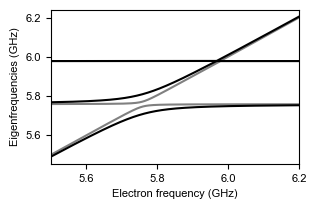

In [30]:
electron_freqs = np.linspace(5.5e9, 6.2e9, 5001)

eigenfrequencies = np.zeros((len(electron_freqs), 3))

fig = plt.figure(figsize=(3.2, 2.))

for Ex, color in zip([0.25e6, 1e6], ['gray', 'black']):
    f0_diff = 5.758e9
    Z0_diff = 200

    omega0 = 2 * np.pi * f0_diff
    cdot = 0.5e-14
    l = Z0_diff / omega0
    
    params = {"c" : 1 / (omega0 ** 2 * l) - 2 * cdot,
              "cdot" : cdot, 
              "l" : l, 
              "omega_e" : 2 * np.pi * 20e9, 
              "alpha_plus_prime" : Ex, 
              "alpha_minus_prime" : -Ex}

    for k, f_e in enumerate(electron_freqs):
        params["omega_e"] = 2 * np.pi * f_e
        efreqs = diagonalize_this(**params)

        eigenfrequencies[k] = np.sort(efreqs)

    for k in range(3):
        label = "" if k == 0 else f"Ex = {Ex/1e6}V/$\mu$m"
        plt.plot(electron_freqs /1e9, eigenfrequencies[:, k] /1e9, color=color, label=label)

    # Estimate 2 * g from the minimum distance.
    print("2g = ", np.min(eigenfrequencies[:, 1] - eigenfrequencies[:, 0]) / 1e6, "MHz")

    plt.xlabel("Electron frequency (GHz)")
    plt.ylabel("Eigenfrequencies (GHz)")
    plt.xlim(electron_freqs.min() / 1e9, electron_freqs.max() /1e9)
    # plt.legend(loc=0, frameon=False)

Indeed, we see that the common mode doesn't have an avoided crossing, whereas the differential mode has an avoided crossing that tunes with the value of `alpha_minus_prime`. 

We determined the apparent $g$ from the avoided crossing, but does this value of $g/2\pi$ make sense? Let's calculate the expected value, which is given by 

$$
    g = \frac{1}{2} e E_x \sqrt{\frac{Z}{m_e \omega_e}}
$$

In [23]:
for Ex in [0.2e6, 0.4e6]:
    print(f"For Ex = {Ex/1e6:0.1f} V/µm, we expect g/2π = {1e-6 * 0.5 * elementary_charge * Ex * np.sqrt(Z0_diff * 2 * np.pi * f0_diff / electron_mass) / (2 * np.pi) : .1f} MHz")

For Ex = 0.2 V/µm, we expect g/2π =  7.2 MHz
For Ex = 0.4 V/µm, we expect g/2π =  14.4 MHz


## Electron counting in the dispersive regime

In [40]:
# Note, a factor of pi/2 accounts for the distributed nature of the capacitance to gnd, inductance and shunt capacitance.
params = {"c" : 2 * 20e-15 / np.pi,
          "cdot" : 0.02e-15 + 3e-15 / np.pi, 
          "l" : 2 * 100e-9 / np.pi, 
          "omega_e" : 2 * np.pi * 20e9, 
          "alpha_plus_prime" : 0.2e6, 
          "alpha_minus_prime" : -0.2e6}

f0_comm = np.sqrt(1 / (params['l'] * (params['c']))) / (2 * np.pi )
f0_diff = np.sqrt(1 / (params['l'] * (params['c'] + 2 * params["cdot"]))) / (2 * np.pi )

print(f"Common mode: {f_comm/1e9:.3f} GHz, Differential mode: {f_diff/1e9:.3f} GHz")

Common mode: 5.590 GHz, Differential mode: 5.206 GHz


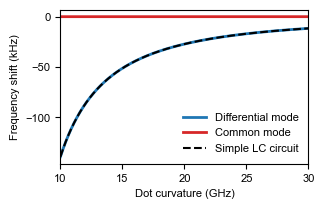

In [43]:
electron_freqs = np.linspace(10e9, 30e9, 5001)

eigenfrequencies = np.zeros((len(electron_freqs), 3))

# Sweep the electron frequency
for k, f_e in enumerate(electron_freqs):
    params["omega_e"] = 2 * np.pi * f_e
    efreqs = diagonalize_this(**params)

    eigenfrequencies[k] = np.sort(efreqs)

fig = plt.figure(figsize=(3.2, 2))

# And from here we calculate the frequency shifts (measured from the bare values)
plt.plot(electron_freqs/1e9, 1e-3 * (eigenfrequencies[:, 0] - f0_diff), color='tab:blue', label='Differential mode', lw=2)
plt.plot(electron_freqs/1e9, 1e-3 * (eigenfrequencies[:, 1] - f0_comm), color='tab:red', label='Common mode', lw=2)

# Calculation of the capacitance change from the dispersive shift of the differential mode.
# The expression comes from a simple LC model, but if the resonance frequency shifts agree then this expression should be valid.
total_capacitance = params['c'] + 2 * params['cdot']
delta_c = 2 * (elementary_charge) ** 2 / (electron_mass * (2 * np.pi) ** 2 * (electron_freqs ** 2 - f0_diff ** 2)) * (0.5 * (params['alpha_plus_prime'] - params['alpha_minus_prime'])) ** 2
simple_lc_shift = -f0_diff * 0.5 * delta_c / total_capacitance

plt.plot(electron_freqs/1e9, 1e-3 * simple_lc_shift, '--', color='black', label="Simple LC circuit")

plt.xlabel("Dot curvature (GHz)")
plt.ylabel("Frequency shift (kHz)")
plt.xlim(electron_freqs.min()/1e9, electron_freqs.max()/1e9)
plt.legend(loc=0, frameon=False)

## Effect of the dot capacitance

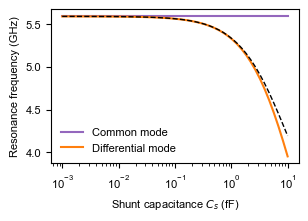

In [57]:
# Note, a factor of pi/2 accounts for the distributed nature of the capacitance to gnd, inductance and shunt capacitance.
params = {"c" : 2 * 20e-15 / np.pi,
          "cdot" : 0.0, 
          "l" : 2 * 100e-9 / np.pi, 
          "omega_e" : 2 * np.pi * 20e9, 
          "alpha_plus_prime" : 0.2e6, 
          "alpha_minus_prime" : -0.2e6}

Cshunt = np.logspace(-18, -14)
f0_comms = np.zeros(len(Cshunt))
f0_diffs = np.zeros(len(Cshunt))

for k, c_s in enumerate(Cshunt):
    params['cdot'] = 2 * c_s / np.pi
    f0_comms[k] = np.sqrt(1 / (params['l'] * (params['c']))) / (2 * np.pi )
    f0_diffs[k] = np.sqrt(1 / (params['l'] * (params['c'] + 2 * params["cdot"]))) / (2 * np.pi )

fig = plt.figure(figsize=(3.2, 2))
plt.plot(Cshunt * 1e15, f0_comms / 1e9, color='tab:purple', label='Common mode')
plt.plot(Cshunt * 1e15, f0_diffs / 1e9, color='tab:orange', label='Differential mode')
plt.plot(Cshunt * 1e15, (f0_comms - f0_comms * Cshunt * 2 / np.pi / (params["c"] + 2 * Cshunt * 2  / np.pi)) / 1e9, '--k', lw=1)
plt.xlabel("Shunt capacitance $C_s$ (fF)")
plt.xscale('log')
plt.ylabel("Resonance frequency (GHz)")
plt.legend(loc=0, frameon=False)

# Interesting story: For high impedance you want low capacitance, but you need some capacitance to split the common and differential mode.
# If the shunt cap is much smaller than the total capacitance, alpha << 1, then the splitting is given by alpha * f0 =  cdot * f0 / c + 2 cdot 

## Capacitance of single electron on differential mode

5.758 5.760084293864052
{'c': 1.3810331980887056e-13, 'cdot': 5e-17, 'l': 5.528132792354822e-09, 'omega_e': 188495559215.38757, 'alpha_plus_prime': 240000.0, 'alpha_minus_prime': -240000.0}


(10.0, 30.0)

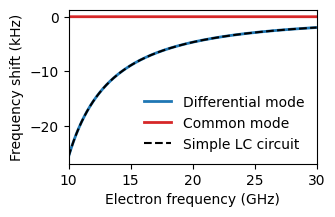

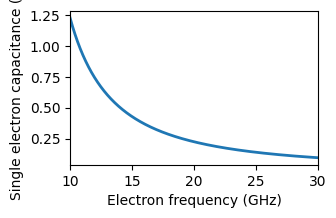

In [37]:
electron_freqs = np.linspace(10e9, 30e9, 5001)

eigenfrequencies = np.zeros((len(electron_freqs), 3))

fig = plt.figure(figsize=(3.2,2))

f0_diff = 5.758e9
Z0_diff = 200
Ex = 0.24e6

# Calculate the resonator parameters from the measured differential mode frequency and estimated impedance
omega0 = 2 * np.pi * f0_diff
cdot = 0.05e-15
l = Z0_diff / omega0
params = {"c" : 1 / (omega0 ** 2 * l) - 2 * cdot,
          "cdot" : cdot, 
          "l" : l, 
          "omega_e" : 2 * np.pi * 20e9, 
          "alpha_plus_prime" : Ex, 
          "alpha_minus_prime" : -Ex}

assert params['c'] > 0, "The calculated capacitance is not physical"

# Sweep the electron frequency
for k, f_e in enumerate(electron_freqs):
    params["omega_e"] = 2 * np.pi * f_e
    efreqs = diagonalize_this(**params)

    eigenfrequencies[k] = np.sort(efreqs)

# The bare common mode frequency can now be calculated
f0_comm = np.sqrt(1 / (params['l'] * params['c'])) / (2 * np.pi)
    
# And from here we calculate the frequency shifts (measured from the bare values)
plt.plot(electron_freqs/1e9, 1e-3 * (eigenfrequencies[:, 0] - f0_diff), color='tab:blue', label='Differential mode', lw=2)
plt.plot(electron_freqs/1e9, 1e-3 * (eigenfrequencies[:, 1] - f0_comm), color='tab:red', label='Common mode', lw=2)

# Calculation of the capacitance change from the dispersive shift of the differential mode.
# The expression comes from a simple LC model, but if the resonance frequency shifts agree then this expression should be valid.
total_capacitance = params['c'] + 2 * params['cdot']
delta_c = 2 * (elementary_charge) ** 2 / (electron_mass * (2 * np.pi) ** 2 * (electron_freqs ** 2 - f0_diff ** 2)) * (0.5 * (params['alpha_plus_prime'] - params['alpha_minus_prime'])) ** 2
simple_lc_shift = -f0_diff * 0.5 * delta_c / total_capacitance

plt.plot(electron_freqs/1e9, 1e-3 * simple_lc_shift, '--', color='black', label="Simple LC circuit")

print(f0_diff/1e9, f0_comm/1e9)
print(params)

plt.xlabel("Electron frequency (GHz)")
plt.ylabel("Frequency shift (kHz)")
plt.xlim(electron_freqs.min()/1e9, electron_freqs.max()/1e9)
plt.legend(loc=0, frameon=False)

fig = plt.figure(figsize=(3.2,2))
plt.plot(electron_freqs/1e9, delta_c * 1e18, lw=2)
plt.xlabel("Electron frequency (GHz)")
plt.ylabel("Single electron capacitance (aF)")
plt.xlim(electron_freqs.min()/1e9, electron_freqs.max()/1e9)

Here we see that 

- The common mode doesn't couple to the electron
- The differential mode shifts order ~10 kHz
- When the dot capacitance is low, the circuit can be approximated easily by the simple LC circuit. The dot capacitance is only a perturbation in this case.

In [34]:
params['c']/params['cdot']

2762.066396177411